In [13]:
#!pip install tensorflow --upgrade

In [110]:
import numpy as np
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, RepeatVector, TimeDistributed, BatchNormalization
from tensorflow.keras import optimizers, initializers

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, accuracy_score
import matplotlib.pyplot as plt

In [15]:
tf.config.optimizer.set_jit(True)

Step 1: Load the data

In [16]:
# data.shape = (K, N), labels.shape = (1000,)
# data: 1000 K time series, each with N timesteps
# labels: N labels (0-good or 1-outlier), corresponding to each time series
name = "testCase0"
data = np.load(name+".npy")
labels = np.load(name+"_labels.npy")
K = data.shape[0]
N = data.shape[1]

### Supervised RNN

Step 2: Reshape and Oversample the Minority Class

In [17]:
# Assume `data` is the (K, N) numpy matrix with time series and `labels` is the (N,) label array
data = data.reshape(K, N, 1)

# Separate majority and minority classes
good_data = data[labels == 0]
bad_data = data[labels == 1]

good_labels = labels[labels == 0]
bad_labels = labels[labels == 1]

# Oversample the minority class (bad_data)
bad_data_oversampled, bad_labels_oversampled = resample(bad_data, bad_labels,
                                                        replace=True,  # Allow resampling with replacement
                                                        n_samples=len(good_data),  # Match the number of "good" data points
                                                        random_state=42)

# Combine the oversampled data with the majority class data
data_oversampled = np.vstack((good_data, bad_data_oversampled))
labels_oversampled = np.hstack((good_labels, bad_labels_oversampled))

# Shuffle the data to ensure random ordering
indices = np.random.permutation(len(labels_oversampled))
data_oversampled = data_oversampled[indices]
labels_oversampled = labels_oversampled[indices]

Step 3: Train-Test Split and Data Standardization

In [18]:
# Split the oversampled data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(data_oversampled, labels_oversampled, test_size=0.2, random_state=42)

# Scale the data (fit only on training data to avoid data leakage)
scaler = StandardScaler()

# Reshape data to 2D for scaling, then back to original shape
X_train_reshaped = X_train.reshape(-1, X_train.shape[-1])
X_test_reshaped = X_test.reshape(-1, X_test.shape[-1])

X_train_scaled = scaler.fit_transform(X_train_reshaped).reshape(X_train.shape)
X_test_scaled = scaler.transform(X_test_reshaped).reshape(X_test.shape)

Step 4: Build the LSTM-based Classifier

In [19]:
# Build a Sequential model with LSTM layers
model = Sequential()

# Add an LSTM layer
model.add(LSTM(128, input_shape=(N, 1), return_sequences=True))  # LSTM for sequence data
model.add(LSTM(64, input_shape=(N, 1), return_sequences=False))  # LSTM for sequence data
model.add(Dense(32, activation='relu'))  # Fully connected layer with 32 units
model.add(Dense(1, activation='sigmoid'))  # Output layer for binary classification

# Compile the model with binary crossentropy loss and Adam optimizer
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Summary of the model
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 500, 128)          66560     
_________________________________________________________________
lstm_3 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dense_2 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total params: 118,081
Trainable params: 118,081
Non-trainable params: 0
_________________________________________________________________


Step 5: Train the Model

In [20]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
history = model.fit(X_train_scaled, y_train, epochs=50, batch_size=128, validation_split=0.1, callbacks=[early_stopping])

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test_scaled, y_test)
print(f'Test Accuracy: {test_accuracy:.4f}')


Epoch 1/50


2024-09-19 15:02:52.492405: W tensorflow/compiler/jit/mark_for_compilation_pass.cc:1652] (One-time warning): Not using XLA:CPU for cluster because envvar TF_XLA_FLAGS=--tf_xla_cpu_global_jit was not set.  If you want XLA:CPU, either set that envvar, or use experimental_jit_scope to enable XLA:CPU.  To confirm that XLA is active, pass --vmodule=xla_compilation_cache=1 (as a proper command-line flag, not via TF_XLA_FLAGS) or set the envvar XLA_FLAGS=--xla_hlo_profile.


107/107 [==============================] - 321s 3s/step - loss: 0.6085 - accuracy: 0.6631 - val_loss: 0.5484 - val_accuracy: 0.7395
Epoch 2/50
107/107 [==============================] - 365s 3s/step - loss: 0.5554 - accuracy: 0.7183 - val_loss: 0.5783 - val_accuracy: 0.6868
Epoch 3/50
107/107 [==============================] - 383s 4s/step - loss: 0.5397 - accuracy: 0.7311 - val_loss: 0.6085 - val_accuracy: 0.6961
Epoch 4/50
107/107 [==============================] - 391s 4s/step - loss: 0.5330 - accuracy: 0.7243 - val_loss: 0.4896 - val_accuracy: 0.7572
Epoch 5/50
107/107 [==============================] - 390s 4s/step - loss: 0.5001 - accuracy: 0.7506 - val_loss: 0.4946 - val_accuracy: 0.7625
Epoch 6/50
107/107 [==============================] - 407s 4s/step - loss: 0.4982 - accuracy: 0.7548 - val_loss: 0.4734 - val_accuracy: 0.7625
Epoch 7/50
107/107 [==============================] - 416s 4s/step - loss: 0.4936 - accuracy: 0.7648 - val_loss: 0.4571 - val_accuracy: 0.7750
Epoch 8/50

In [103]:
# Plot the training and validation loss over epochs
def plot_history(history, plus_accuracy = True):
    # Get the values from the history object
    loss = history.history['loss']
    val_loss = history.history['val_loss']    
    epochs = range(1, len(loss) + 1)
    
    # Plot Loss
    plt.figure(figsize=(14, 6))

    # Subplot 1: Loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Subplot 2: Accuracy
    if plus_accuracy:
        accuracy = history.history['accuracy']
        val_accuracy = history.history['val_accuracy']

        plt.subplot(1, 2, 2)
        plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
        plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
        plt.title('Training and Validation Accuracy')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend()

    # Display the plots
    plt.tight_layout()
    plt.show()

In [ ]:
# Call the plot_history function to visualize the training process
plot_history(history)

In [22]:
name = "val_testCase0"
val_data = np.load(name+".npy")
val_labels = np.load(name+"_labels.npy")
val_K = val_data.shape[0]

In [23]:
val_data = val_data.reshape(val_K, N, 1)
X_val_reshaped = val_data.reshape(-1, val_data.shape[-1])
X_val_scaled = scaler.transform(X_val_reshaped).reshape(val_data.shape)

In [24]:
val_loss, val_accuracy = model.evaluate(X_val_scaled, val_labels)
print(f'Validation Accuracy: {val_accuracy:.4f}')

# Predict probabilities on the validation set
y_val_pred_probs = model.predict(X_val_scaled)

# Compute AUROC
val_auroc = roc_auc_score(val_labels, y_val_pred_probs)
print(f'Validation AUROC: {val_auroc:.4f}')

32/32 [==============================] - 67s 2s/step - loss: 0.2678 - accuracy: 0.8880
Validation Accuracy: 0.8880
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Validation AUROC: 0.8945


### Unsupervised RNN (autoencoder)

In [86]:
np.random.shuffle(data)
data.shape

(10000, 500, 1)

In [87]:
KG = data.shape[0]

Test both scaling and normalization.

In [88]:
scaler_auto = StandardScaler()
data_scaled = scaler_auto.fit_transform(data.reshape(-1, 1)).reshape(KG, N, 1)
data_norm = (data - data.min()) / (data.max() - data.min())

Check for NaN and inf 

In [89]:
print(np.isnan(data_scaled).sum())  # Check for NaN values
print(np.isinf(data_scaled).sum())  # Check for infinite values
print(np.isnan(data_norm).sum())  # Check for NaN values
print(np.isinf(data_norm).sum())  # Check for infinite values

0
0
0
0


Check 
- Adam and RMSprop
- learning_rate=1e-4, learning_rate=1e-5
- clipnorm=1.0, clipvalue=1.0
- different batch sizes
- batch normalization

In [94]:
# Define the Autoencoder model (LSTM-based)
model = Sequential()
model.add(LSTM(64, activation='relu', input_shape=(N, 1), return_sequences=False))
model.add(BatchNormalization())
model.add(RepeatVector(N))  # Repeat vector to match the input shape for decoding
model.add(LSTM(64, activation='relu', return_sequences=True))
model.add(TimeDistributed(Dense(1)))  # Output layer with the same time steps

# Compile the model
# optimizers.Adam
model.compile(optimizer=optimizers.RMSprop(learning_rate=1e-5, clipnorm=1.0), loss='mse')

# Summary of the model
model.summary()

In [95]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model on the majority class (you can identify majority class data via labels or all data assuming unsupervised setting)
history = model.fit(data_norm, data_norm, 
                    epochs=50, batch_size=128, validation_split=0.1, 
                    callbacks=[early_stopping])

Epoch 1/50
71/71 [==============================] - 62s 847ms/step - loss: 0.2340 - val_loss: 0.2802
Epoch 2/50
71/71 [==============================] - 58s 812ms/step - loss: 0.2109 - val_loss: 0.2704
Epoch 3/50
71/71 [==============================] - 56s 789ms/step - loss: 0.1900 - val_loss: 0.2585
Epoch 4/50
71/71 [==============================] - 59s 832ms/step - loss: 0.1708 - val_loss: 0.2442
Epoch 5/50
71/71 [==============================] - 56s 791ms/step - loss: 0.1529 - val_loss: 0.2257
Epoch 6/50
71/71 [==============================] - 60s 850ms/step - loss: 0.1369 - val_loss: 0.2021
Epoch 7/50
71/71 [==============================] - 63s 887ms/step - loss: 0.1220 - val_loss: 0.1726
Epoch 8/50
71/71 [==============================] - 58s 813ms/step - loss: 0.1094 - val_loss: 0.1396
Epoch 9/50
71/71 [==============================] - 57s 797ms/step - loss: 0.0992 - val_loss: 0.1100
Epoch 10/50
71/71 [==============================] - 59s 830ms/step - loss: 0.0911 - val_lo

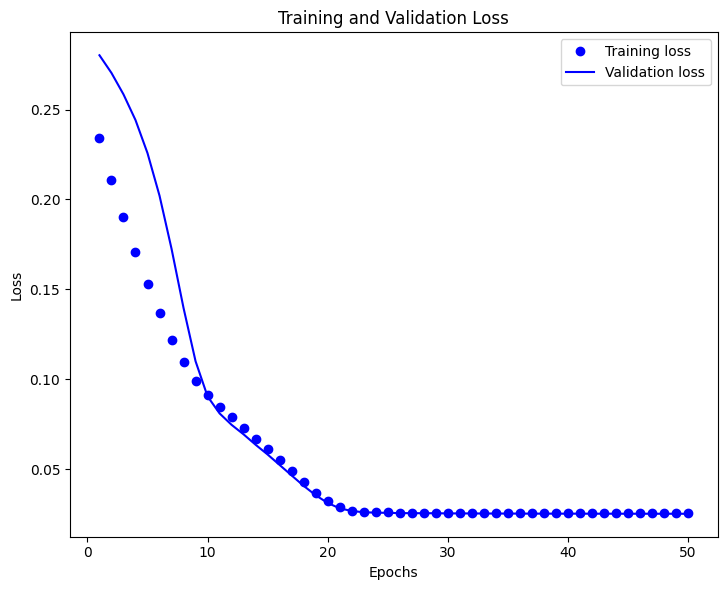

In [104]:
plot_history(history, False)

In [108]:
# Predict the reconstructed data
def get_anomalies(data, percentile):
    reconstructed_data = model.predict(data)

    # Calculate the reconstruction error
    reconstruction_error = np.mean(np.power(data - reconstructed_data, 2), axis=1)

    # Set a threshold for anomaly detection based on the reconstruction error
    threshold = np.percentile(reconstruction_error, percentile)  # Example: top 5% highest errors are anomalies

    # Classify time series as anomalies if their reconstruction error exceeds the threshold
    # anomalies is a boolean array, where True indicates a likely "bad" time series
    anomalies = reconstruction_error > threshold    
    prediction_labels = np.where(anomalies, 0, 1)
    
    return prediction_labels, reconstruction_error 

In [111]:
X_val_scaled = scaler_auto.transform(val_data.reshape(-1, val_data.shape[-1])).reshape(val_data.shape)
X_val_norm = (val_data - data.min()) / (data.max() - data.min())

y_val_pred, y_val_pred_probs = get_anomalies(X_val_norm, 95)
val_accuracy = accuracy_score(val_labels, y_val_pred)    
print(f'Validation Accuracy: {val_accuracy:.4f}')
val_auroc = roc_auc_score(val_labels, y_val_pred_probs)
print(f'Validation AUROC: {val_auroc:.4f}')

Validation Accuracy: 0.9080
Validation AUROC: 0.5812


### Short window classifier

In [144]:
def sliding_window(dataset, history_size, label:int):
    data = []
    labels = []
    start_index = history_size
    end_index = len(dataset[0])    
    for c in range(len(dataset)):
        for i in range(start_index, end_index):
            indices = range(i-history_size, i)
            # Reshape data from (history_size,) to (history_size, 1)
            data.append(np.reshape(dataset[c][indices], (history_size, 1)))
            labels.append(label)
    return np.array(data), np.array(labels)

In [151]:
past_history = 200 #hours
good_data_windows, good_labels_windows = sliding_window(good_data, past_history, 0)
bad_data_windows, bad_labels_windows = sliding_window(bad_data, past_history, 1)

In [152]:
# Oversample the minority class (bad_data)
bad_data_windows_oversampled, bad_labels_windows_oversampled = resample(bad_data_windows, bad_labels_windows,
                                                        replace=True,  # Allow resampling with replacement
                                                        n_samples=len(good_data_windows),  # Match the number of "good" data points
                                                        random_state=42)

# Combine the oversampled data with the majority class data
data_windows_oversampled = np.vstack((good_data_windows, bad_data_windows_oversampled))
labels_windows_oversampled = np.hstack((good_labels_windows, bad_labels_windows_oversampled))

# Shuffle the data to ensure random ordering
indices = np.random.permutation(len(labels_windows_oversampled))
data_windows_oversampled = data_windows_oversampled[indices]
labels_windows_oversampled = labels_windows_oversampled[indices]

In [153]:
data_windows_oversampled.shape

(5700000, 200, 1)

In [154]:
# Split the oversampled data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(data_windows_oversampled, labels_windows_oversampled, test_size=0.2, random_state=42)

# Scale the data (fit only on training data to avoid data leakage)
scaler = StandardScaler()

# Reshape data to 2D for scaling, then back to original shape
X_train_reshaped = X_train.reshape(-1, X_train.shape[-1])
X_test_reshaped = X_test.reshape(-1, X_test.shape[-1])

X_train_scaled = scaler.fit_transform(X_train_reshaped).reshape(X_train.shape)
X_test_scaled = scaler.transform(X_test_reshaped).reshape(X_test.shape)

In [160]:
# Build a Sequential model with LSTM layers
model = Sequential()

# Add an LSTM layer
model.add(LSTM(128, input_shape=(past_history, 1), return_sequences=True))  # LSTM for sequence data
model.add(Dense(32, activation='relu'))  # Fully connected layer with 32 units
model.add(Dense(1, activation='sigmoid'))  # Output layer for binary classification

# Compile the model with binary crossentropy loss and Adam optimizer
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Summary of the model
model.summary()

Model: "sequential_30"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_55 (LSTM)               (None, 200, 128)          66560     
_________________________________________________________________
dense_33 (Dense)             (None, 200, 32)           4128      
_________________________________________________________________
dense_34 (Dense)             (None, 200, 1)            33        
Total params: 70,721
Trainable params: 70,721
Non-trainable params: 0
_________________________________________________________________


In [161]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
history = model.fit(X_train_scaled, y_train, epochs=50, batch_size=128, validation_split=0.1, callbacks=[early_stopping])

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test_scaled, y_test)
print(f'Test Accuracy: {test_accuracy:.4f}')

Epoch 1/50
32063/32063 [==============================] - 19874s 620ms/step - loss: 0.4128 - accuracy: 0.7946 - val_loss: 0.3345 - val_accuracy: 0.8400
Epoch 2/50
32063/32063 [==============================] - 22003s 686ms/step - loss: 0.2895 - accuracy: 0.8623 - val_loss: 0.2616 - val_accuracy: 0.8757
Epoch 3/50
32063/32063 [==============================] - 22510s 702ms/step - loss: 0.2342 - accuracy: 0.8882 - val_loss: 0.2171 - val_accuracy: 0.8958
Epoch 4/50
32063/32063 [==============================] - 43702s 1s/step - loss: 0.2034 - accuracy: 0.9018 - val_loss: 0.1890 - val_accuracy: 0.9081
Epoch 5/50
  898/32063 [..............................] - ETA: 100:11:13 - loss: 0.1912 - accuracy: 0.9071

IOStream.flush timed out


32063/32063 [==============================] - 322741s 10s/step - loss: 0.1839 - accuracy: 0.9105 - val_loss: 0.1756 - val_accuracy: 0.9142
Epoch 6/50
32063/32063 [==============================] - 21323s 665ms/step - loss: 0.1706 - accuracy: 0.9164 - val_loss: 0.1637 - val_accuracy: 0.9195
Epoch 7/50
32063/32063 [==============================] - 22334s 697ms/step - loss: 0.1607 - accuracy: 0.9209 - val_loss: 0.1520 - val_accuracy: 0.9247
Epoch 8/50
32063/32063 [==============================] - 22878s 714ms/step - loss: 0.1525 - accuracy: 0.9247 - val_loss: 0.1577 - val_accuracy: 0.9235
Epoch 9/50
32063/32063 [==============================] - 27881s 870ms/step - loss: 0.1452 - accuracy: 0.9280 - val_loss: 0.1401 - val_accuracy: 0.9303
Epoch 10/50
32063/32063 [==============================] - 25271s 788ms/step - loss: 0.1396 - accuracy: 0.9306 - val_loss: 0.1392 - val_accuracy: 0.9308
Epoch 11/50
32063/32063 [==============================] - 23380s 729ms/step - loss: 0.1348 - accur